In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import pyproj
import sys
import itertools
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

base = 'C:/Users/Antonin_JOLY/Desktop/93-human-gait-database'
metadata = pd.read_csv(os.path.join(base,'MetaData_subjects.csv'),index_col=0)
part_res = '-rp-s2'
subjects = [i.split('-')[0] for i in metadata.iloc[:,1]]
metadata.index = subjects

Using TensorFlow backend.


In [43]:
# metadata.hist(figsize=(10,10),bins=40,xlabelsize=10)
metadata

,subject_left_waist_session1,subject_right_pocket_session1,subject_left_waist_session2,subject_right_pocket_session2,Weight,Age,Height (CM),exercise,Exercise Time (Minutes),smoker,gender,Exercise Time (Minutes/Week)
sub1,sub1-lw-s1.csv,sub1-rp-s1.csv,sub1-lw-s2.csv,sub1-rp-s2.csv,68,30,180,2,40,No,M,80
sub2,sub2-lw-s1.csv,sub2-rp-s1.csv,sub2-lw-s2.csv,sub2-rp-s2.csv,61,20,170,2,30,No,F,60
sub3,sub3-lw-s1.csv,sub3-rp-s1.csv,sub3-lw-s2.csv,sub3-rp-s2.csv,75,24,175,4,60,No,M,240
sub4,sub4-lw-s1.csv,sub4-rp-s1.csv,sub4-lw-s2.csv,sub4-rp-s2.csv,49,18,150,2,15,No,F,30
sub5,sub5-lw-s1.csv,sub5-rp-s1.csv,sub5-lw-s2.csv,sub5-rp-s2.csv,59,18,152,4,90,No,F,360
...,...,...,...,...,...,...,...,...,...,...,...,...
sub89,sub89-lw-s1.csv,sub89-rp-s1.csv,sub89-lw-s2.csv,sub89-rp-s2.csv,82,18,165,0,15,No,F,0
sub90,sub90-lw-s1.csv,sub90-rp-s1.csv,sub90-lw-s2.csv,sub90-rp-s2.csv,61,20,170,2,60,No,F,120
sub91,sub91-lw-s1.csv,sub91-rp-s1.csv,sub91-lw-s2.csv,sub91-rp-s2.csv,63,22,175,4,60,No,F,240
sub92,sub92-lw-s1.csv,sub92-rp-s1.csv,sub92-lw-s2.csv,sub92-rp-s2.csv,79,21,170,2,20,No,F,40


In [44]:
def gps_to_ecef_pyproj(lat, lon, alt):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    x, y, z = pyproj.transform(lla, ecef, lon, lat, alt, radians=False)
    return x, y, z

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        data=(data-data.mean())/data.std()
    elif method == 'minmax':
        # Min-max normalization
        data=(data-data.min())/(data.max()-data.min())
    return data

'loggingTime.txt.', 'loggingSample.N.', 'identifierForVendor.txt.','deviceID.txt.', 'locationTimestamp_since1970.s.',
'locationLatitude.WGS84.', 'locationLongitude.WGS84.','locationAltitude.m.', 'locationSpeed.m.s.', 'locationCourse...',
'locationVerticalAccuracy.m.', 'locationHorizontalAccuracy.m.','locationFloor.Z.', 'locationHeadingTimestamp_since1970.s.',
'locationHeadingX.µT.', 'locationHeadingY.µT.', 'locationHeadingZ.µT.','locationTrueHeading...', 'locationMagneticHeading...',
'locationHeadingAccuracy...', 'accelerometerTimestamp_sinceReboot.s.','gyroTimestamp_sinceReboot.s.', 'gyroRotationX.rad.s.',
'gyroRotationY.rad.s.', 'gyroRotationZ.rad.s.','motionTimestamp_sinceReboot.s.', 'motionYaw.rad.', 'motionRoll.rad.',
'motionPitch.rad.', 'motionRotationRateX.rad.s.','motionRotationRateY.rad.s.', 'motionRotationRateZ.rad.s.',
'motionUserAccelerationX.G.', 'motionUserAccelerationY.G.','motionUserAccelerationZ.G.', 'motionAttitudeReferenceFrame.txt.',
'motionQuaternionX.R.', 'motionQuaternionY.R.', 'motionQuaternionZ.R.','motionQuaternionW.R.', 'motionGravityX.G.', 'motionGravityY.G.',
'motionGravityZ.G.', 'motionMagneticFieldX.µT.','motionMagneticFieldY.µT.', 'motionMagneticFieldZ.µT.',
'motionMagneticFieldCalibrationAccuracy.Z.','activityTimestamp_sinceReboot.s.', 'activity.txt.',
'activityActivityConfidence.Z.', 'activityActivityStartDate.txt.','pedometerStartDate.txt.', 'pedometerNumberofSteps.N.',
'pedometerDistance.m.', 'pedometerFloorAscended.N.','pedometerFloorDescended.N.', 'pedometerEndDate.txt.',
'altimeterTimestamp_sinceReboot.s.', 'altimeterReset.bool.','altimeterRelativeAltitude.m.', 'altimeterPressure.kPa.',
'deviceOrientation.Z.', 'batteryState.R.', 'batteryLevel.Z.','avAudioRecorderPeakPower.dB.', 'avAudioRecorderAveragePower.dB.',
'state.N.', 'Df1.1$X', 'Df1.1$Y', 'Df1.1$Z', 'Df1.1$Label'

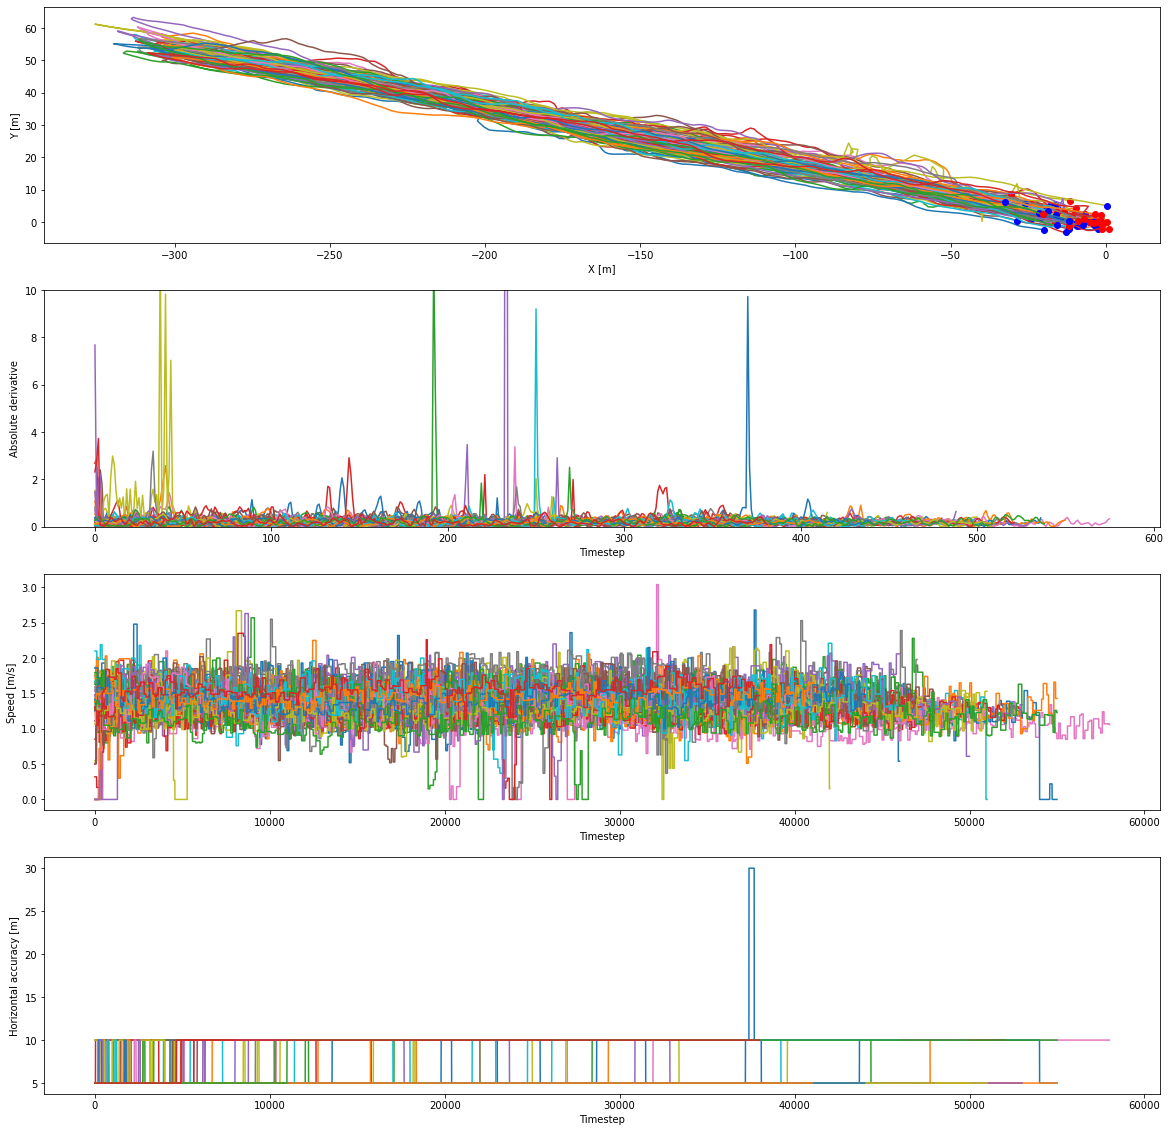

In [57]:
def plot_traj(base_folder, sub, sensor_pos):
    def remove_duplicate(x,y):
        pts = list(zip(x,y))
        x, y = zip(*[k for k, g in itertools.groupby(pts)])
        return np.array(x),np.array(y)
    traj_list = [[],[]]
    diff_list = []
    sub_list = []
    for idx, s in enumerate(sub):
        path = os.path.join(base_folder,'subjects/%s%s.csv'%(s,sensor_pos)).replace('\sub','/sub')
        try:
            data_sub = pd.read_csv(path)
            lla_col = sorted([k for k in data_sub.columns if 'locationLatitude' in k or 'locationLongitude' in k])
            lat, lon = data_sub.loc[:,lla_col[0]], data_sub.loc[:,lla_col[1]]
            x,y,_ = gps_to_ecef_pyproj(lat.to_numpy(), lon.to_numpy(), np.array([0 for i in range(len(lat))]))
            x,y = remove_duplicate(x,y)
                        
            plt.subplot(4,1,1)
            plt.plot(x - 1534970, y + 4467506)
            plt.plot(x[0] - 1534970,y[0] + 4467506,'ro')
            plt.plot(x[-1] - 1534970,y[-1] + 4467506,'bo')
            plt.xlabel('X [m]')
            plt.ylabel('Y [m]')

            plt.subplot(4,1,2)
            derivative = np.abs(np.gradient(y)/np.gradient(x))
            plt.plot([i for i in range(len(derivative))],derivative)
            plt.ylim(0,10)
            plt.xlabel('Timestep')
            plt.ylabel('Absolute derivative')

            plt.subplot(4,1,3)
            speed = data_sub.loc[:,'locationSpeed.m.s.']
            plt.plot([i for i in range(len(speed))],speed)
            plt.xlabel('Timestep')
            plt.ylabel('Speed [m/s]')
            
            plt.subplot(4,1,4)
            acc = data_sub.loc[:,'locationHorizontalAccuracy.m.']
            plt.plot([i for i in range(len(acc))],acc)
            plt.xlabel('Timestep')
            plt.ylabel('Horizontal accuracy [m]')
#             traj_list[0].append(list(x))
#             traj_list[1].append(list(y))
#             traj_list.append(list(map(list, zip(x, y))))
            diff_list.append(list(derivative))
            sub_list.append(s.replace('%s.csv'%(part),''))
        except:
            pass
    plt.show()
    return traj_list, diff_list, sub_list

plt.figure(figsize=(20,20))
traj_list, diff_list, sub_list = plot_traj(base, subjects, part_res)

total 54 over 20 under 34
[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


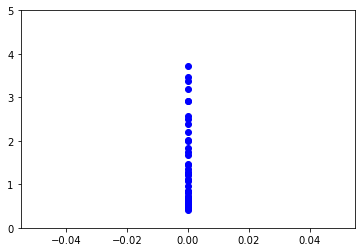

In [58]:
std_res = [np.max(i) for i in diff_list]
plt.plot([0 for i in range(len(std_res))], std_res,'bo')
plt.ylim(0,5)
tresh = 1.5
print('total',len(std_res),'over',len([i for i in std_res if i > tresh]),'under',len([i for i in std_res if i < tresh]))
label = [1 if i > tresh else 0 for i in std_res]
print(label)

In [61]:
print(np.array(traj_list))

[[list([1534968.3638506061, 1534966.9534608324, 1534965.8129944014, 1534964.5177102895, 1534963.0970654746, 1534961.716486412, 1534960.3089341496, 1534959.054921738, 1534957.8063543313, 1534956.5372345715, 1534955.3960107074, 1534954.241954359, 1534952.8135906283, 1534951.3598643942, 1534949.9451134393, 1534948.5818891558, 1534947.279002089, 1534946.1077514824, 1534944.9762344884, 1534943.8012650148, 1534942.6088916007, 1534941.11083328, 1534939.6654644865, 1534938.5274129966, 1534937.2665360272, 1534936.0677725675, 1534934.890298588, 1534933.5603036503, 1534932.345154607, 1534931.128987436, 1534929.7530056029, 1534928.3863542054, 1534926.9944128292, 1534925.7295363988, 1534924.540718578, 1534923.2834903733, 1534922.0967094025, 1534920.873249626, 1534919.8344907542, 1534918.6519492394, 1534917.3883523066, 1534916.2316932967, 1534915.0019588193, 1534913.7521916304, 1534912.4429180832, 1534911.0265410377, 1534909.7116787212, 1534908.5752194258, 1534907.444277603, 1534905.9659546698, 1534

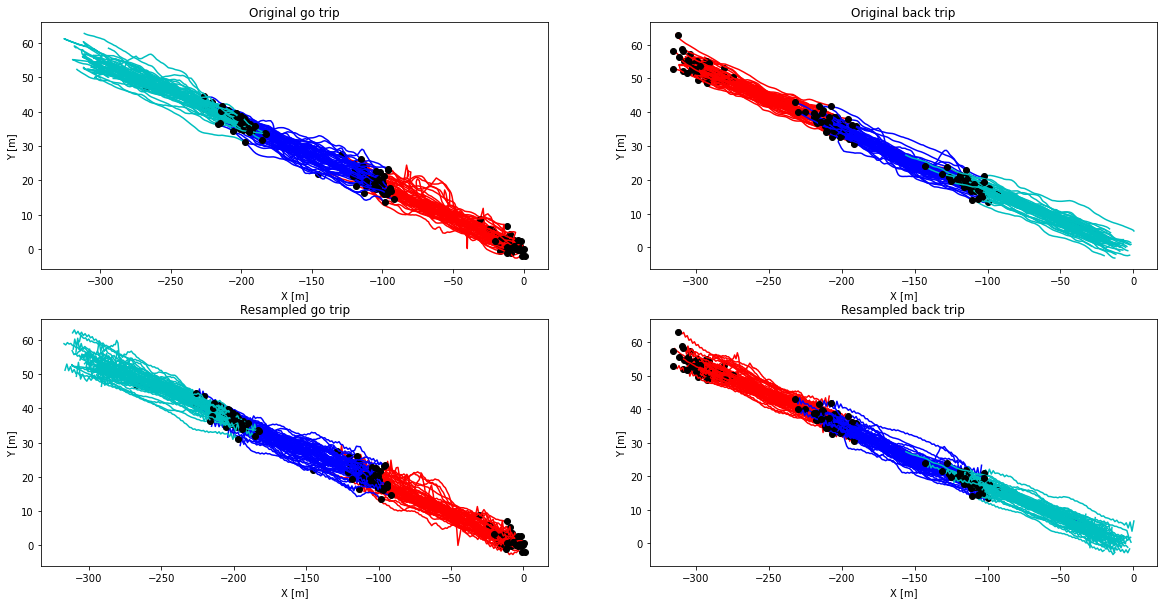

In [29]:
# def process_points(pts, data, label, pt_num = 80):
#     def window(a, w = 128, overlap = 2):
#         view = np.lib.stride_tricks.as_strided(a, strides = a.strides * 2, shape = (a.size - w + 1, w))[0::overlap]
#         return view
#     def get_label(x,y):
#         derivative = np.gradient(y)/np.gradient(x)
#         if x[0] > x[-1] and np.std(derivative) < 0.3:
#             lab = 0
#         elif x[0] < x[-1] and np.std(derivative) < 0.3:
#             lab = 1
#         elif x[0] > x[-1] and np.std(derivative) > 0.3:
#             lab = 2
#         elif x[0] < x[-1] and np.std(derivative) > 0.3:
#             lab = 3
#         if x[0] > x[-1]:
#             lab = 0
#         else:
#             lab = 1
#         return lab
#     x_pt, y_pt = pts[:,0], pts[:,1]
    

#     if len(pts[:,0])!=pt_num:
#         x_pt = np.linspace(x_pt[0], x_pt[-1], pt_num)
#         y_pt = signal.resample(y_pt, pt_num)
#     data.append(np.array([x_pt,y_pt]))
#     label.append(get_label(x_pt,y_pt))
#     return x_pt, y_pt, data, label

# traj_cluster = []
# data_cluster = []
# label_cluster = []

# for traj in traj_list:
#     traj_cluster.append(np.array_split(np.array(traj),6))

# plt.figure(figsize=(20,10))
# for i in np.transpose(traj_cluster)[0]:
#     plt.subplot(2,2,1)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'r')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original go trip')
#     plt.subplot(2,2,3)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'r')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled go trip')
# for i in np.transpose(traj_cluster)[1]:
#     plt.subplot(2,2,1)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'b')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original go trip')
#     plt.subplot(2,2,3)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'b')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled go trip')
# for i in np.transpose(traj_cluster)[2]:
#     plt.subplot(2,2,1)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'c')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original go trip')
#     plt.subplot(2,2,3)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'c')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled go trip')
    
# for i in np.transpose(traj_cluster)[3]:
#     plt.subplot(2,2,2)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'r')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original back trip')
#     plt.subplot(2,2,4)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'r')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled back trip')
# for i in np.transpose(traj_cluster)[4]:
#     plt.subplot(2,2,2)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'b')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original back trip')
#     plt.subplot(2,2,4)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'b')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled back trip')
# for i in np.transpose(traj_cluster)[5]:
#     plt.subplot(2,2,2)
#     plt.plot(i[:,0] - 1534970, i[:,1] + 4467506,'c')
#     plt.plot(i[:,0][0] - 1534970, i[:,1][0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Original back trip')
#     plt.subplot(2,2,4)
#     x_pt, y_pt, data_cluster, label_cluster = process_points(i, data_cluster, label_cluster)
#     plt.plot(x_pt - 1534970, y_pt + 4467506,'c')
#     plt.plot(x_pt[0] - 1534970, y_pt[0] + 4467506,'ko')
#     plt.xlabel('X [m]')
#     plt.ylabel('Y [m]')
#     plt.title('Resampled back trip')


In [30]:
data = np.array([l.tolist() for l in data_cluster]).reshape(324,80,2)
label = np.array(label_cluster)
print(data.shape)

(324, 80, 2)


In [35]:
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.33, random_state=42)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(np.unique(y_train))

[0. 1.]


In [39]:
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], 2, y_train.shape[1]

# # reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 20

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, -1, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1, -1, n_features))

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=40, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

# evaluate model
_, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)

In [40]:
print(accuracy)

0.4953271150588989


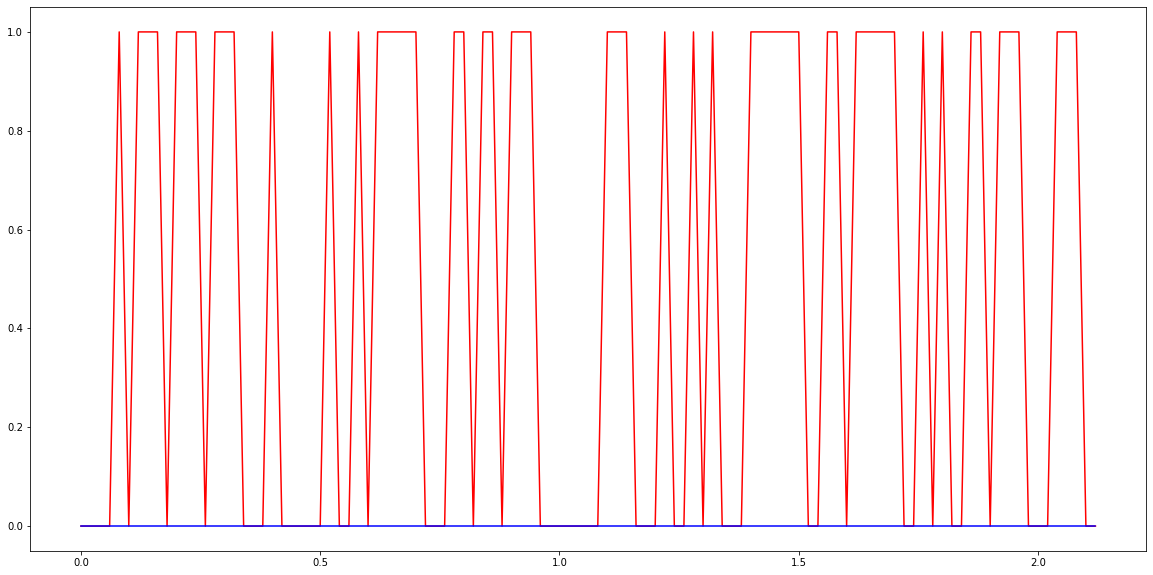

In [41]:
gt = [np.argmax(k, axis=None, out=None) for k in y_val]
pred = [np.argmax(k, axis=None, out=None) for k in model.predict(X_val, verbose=0)]

plt.figure(figsize=(20,10))
plt.plot([k*0.02 for k in range(len(gt))],gt,'r')
plt.plot([k*0.02 for k in range(len(pred))],pred,'b')